# Bonus1: Parallel Algorithms

### Name: Ayman Elkfrawy


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [64]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [65]:
from sklearn.model_selection import train_test_split

split_random_state = 376

y = y.reshape(len(y), 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.16)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (645, 8)
Shape of x_test: (123, 8)
Shape of y_train: (645, 1)
Shape of y_test: (123, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [66]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.27864308  0.03758729 -0.02998267  0.10722333  0.106165    0.01002021
  -0.00890055 -0.11505426]]
test std = 
[[0.82651628 1.14970787 0.99312144 1.01496174 1.11771912 1.17845981
  0.81919962 0.99679393]]


## 1.4. Add a dimension of all ones

In [67]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (645, 9)
Shape of x_test: (123, 9)


In [68]:
import math

VERBOSE = False

class Worker:
    def __init__(self, worker_id, x, y):
        self.x = x
        self.y = y
        self.n_samples = x.shape[0]
        self.d_features = x.shape[1]
        self.w = numpy.zeros((d, 1))
        self.worker_id = worker_id
        self.log('Created')
        self.last_index = 0
        self.epoch_objs = []
        self.sgd_obj_acc = 0  # accumulated SGD objective value

    def log(self, message):
        if VERBOSE:
            print(f'Worker ({self.worker_id}): {message}')

    def set_params(self, w):
        self.log('Received Updated Params')
        self.w = w

    def sgd_grad_objective(self, lam):
        self.log('Calculating SGD grad/loss')
        if self.last_index >= self.n_samples:  # one epoch is done
            # Shuffle the samples
            rand_indices = numpy.random.permutation(self.n_samples)
            self.x = self.x[rand_indices, :]
            self.y = self.y[rand_indices, :]
            self.epoch_objs.append(self.sgd_obj_acc / self.n_samples)  # add per epoch obj value
            self.sgd_obj_acc = 0
            self.last_index = 0

        xi = self.x[self.last_index, :]
        yi = float(self.y[self.last_index, :])
        self.last_index += 1

        yx = yi * xi
        yxw = float(numpy.dot(yx, self.w))

        loss = numpy.log(1 + numpy.exp(-yxw))
        obj = loss + lam / 2 * numpy.sum(self.w * self.w)
        self.sgd_obj_acc += obj

        g = -yx.T / (1 + numpy.exp(yxw)) + lam * self.w

        return g, obj

    def gd_grad_objective(self, lam):
        self.log('Calculating GD grad/loss')
        yx = numpy.multiply(self.y, self.x)
        yxw = numpy.dot(yx, self.w)
        loss = numpy.mean(numpy.log(1 + numpy.exp(-yxw)))
        obj = loss + lam / 2 * numpy.sum(self.w * self.w)
        self.epoch_objs.append(obj)  # add per epoch obj value

        g_vec = numpy.divide(yx, 1 + numpy.exp(yxw))
        grad = -numpy.mean(g_vec, axis=0).reshape(self.d_features, 1) + lam * self.w
        return grad, obj

    def fed_avg(self, n_local_grads, algorithm, learn_rate, lam):
        self.log('Performing FedAvg')
        objval = 0
        for iteration in range(n_local_grads):
            if algorithm == 'sgd':
                g, obj = self.sgd_grad_objective(lam)
            else:
                g, obj = self.gd_grad_objective(lam)
            self.w -= learn_rate * g
            objval += obj

        objval /= n_local_grads
        return self.w, objval


class Server:
    def __init__(self, m, n, d):
        self.m_workers = m
        self.n_samples = n
        self.d_features = d
        self.w = numpy.zeros((d, 1))
        self.obj = 0
        self.log('Created')

    def log(self, message):
        if VERBOSE:
            print(f'Server: {message}')

    def broadcast(self):
        self.log('Broadcasting')
        return self.w

    def aggregate(self, params, objvals):
        self.log('Aggregating')
        self.w = numpy.zeros((self.d_features, 1))
        self.obj = 0
        for worker in range(self.m_workers):
            self.w += params[worker]
            self.obj += objvals[worker]

        # Average results
        self.w /= self.m_workers
        self.obj /= self.m_workers


def create_server_workers(m_workers, x, y):
    n_samples, d_features = x.shape
    s = math.floor(n_samples / m_workers)
    server = Server(m_workers, n_samples, d_features)
    workers = []

    for i in range(m_workers):
        indices = list(range(i*s, (i+1) * s))
        worker = Worker('worker'+str(i), x[indices, :], y[indices, :])
        workers.append(worker)

    return server, workers

In [69]:
def run_fed_avg(x_train, y_train, q=8, algorithm='gd', m_workers=4, lam=1e-6, alpha=1e-1, max_epoch=50):
    server, workers = create_server_workers(m_workers, x_train, y_train)

    iterations_per_epoch = 1
    if algorithm == 'sgd':  # Iterate more for SGD to achieve target epochs
        iterations_per_epoch = math.ceil(x_train.shape[0] / (q * m_workers))

    adjusted_epoch = max_epoch
    if algorithm == 'gd':  # Adjust max_epochs in case GD with q > 1
        adjusted_epoch = math.ceil(max_epoch / q)

    for epoch in range(adjusted_epoch):
        objval = 0
        for iteration in range(iterations_per_epoch):
            w = server.broadcast()
            for i in range(m_workers):
                workers[i].set_params(w)

            params = []
            objs = []

            for worker in workers:
                w_i, obj_i = worker.fed_avg(q, algorithm, alpha, lam)
                params.append(w_i)
                objs.append(obj_i)

            server.aggregate(params, objs)
            objval += server.obj

        if algorithm == 'sgd':
            alpha *= 0.9

        objval = objval / iterations_per_epoch
        print('Objective function value = ' + str(objval))

    objvals = numpy.zeros(max_epoch)
    for worker in workers:
        objvals += worker.epoch_objs[: max_epoch]
    objvals /= m_workers

    return server.w, objvals


_, gd_1q_objvals = run_fed_avg(x_train, y_train, q=1, algorithm='gd', m_workers=4, lam=1e-6, alpha=1e-1, max_epoch=50)
print('-------------------------')
_, gd_8q_objvals = run_fed_avg(x_train, y_train, q=8, algorithm='gd', m_workers=4, lam=1e-6, alpha=1e-1, max_epoch=50)
print('-------------------------')
_, sgd_1q_objvals = run_fed_avg(x_train, y_train, q=1, algorithm='sgd', m_workers=4, lam=1e-6, alpha=1e-1, max_epoch=50)
print('-------------------------')
w_sgd8, sgd_8q_objvals = run_fed_avg(x_train, y_train, q=8, algorithm='sgd', m_workers=4, lam=1e-6, alpha=1e-1, max_epoch=50)

Objective function value = 0.6751081205911709
Objective function value = 0.6348391633418111
Objective function value = 0.6056000297849438
Objective function value = 0.5838070309712494
Objective function value = 0.5671373789394729
Objective function value = 0.5540836983613195
Objective function value = 0.543650219585911
Objective function value = 0.5351632771130821
Objective function value = 0.5281555433526319
Objective function value = 0.5222948578792821
Objective function value = 0.5173397115710356
Objective function value = 0.5131108054301742
Objective function value = 0.5094724728676128
Objective function value = 0.5063202787943275
Objective function value = 0.5035725689721365
Objective function value = 0.5011645981698157
Objective function value = 0.49904437521072315
Objective function value = 0.49716967248177035
Objective function value = 0.49550583911968427
Objective function value = 0.4940241780270924
Objective function value = 0.4927007245775833
Objective function value = 0.491

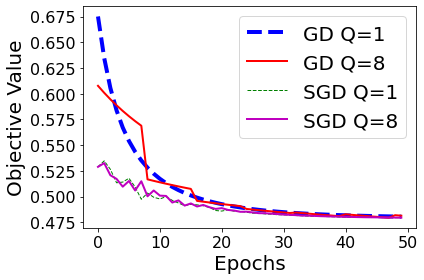

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs = range(len(gd_1q_objvals))

line0, = plt.plot(epochs, gd_1q_objvals, '--b', linewidth=4)
line1, = plt.plot(epochs, gd_8q_objvals, '-r', linewidth=2)
line2, = plt.plot(epochs, sgd_1q_objvals, '--g', linewidth=1)
line3, = plt.plot(epochs, sgd_8q_objvals, '-m', linewidth=2)

plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Objective Value', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend([line0, line1, line2, line3], ['GD Q=1', 'GD Q=8', 'SGD Q=1', 'SGD Q=8'], fontsize=20)
plt.tight_layout()
plt.show()

In [71]:
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

# evaluate training error using SGD Q=8 params
w = w_sgd8
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.22790697674418606


In [72]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.21138211382113822
